<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Convolutional%20neural%20network/Multiclass_image_Classification_with_Deep_Learning_and_70_dogs_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d gpiosenka/70-dog-breedsimage-data-set

 99% 212M/215M [00:09<00:00, 21.4MB/s]
100% 215M/215M [00:09<00:00, 23.6MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/70-dog-breedsimage-data-set.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


Importing library and data

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow

from pathlib import Path
import os.path

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout

from keras.models import Model
import keras.backend as K 
from keras.models import Sequential

In [ ]:
train_dir = Path('/content/train')
test_dir = Path('/content/test')
validation_dir = Path('/content/valid')

Get filepath and labels

In [ ]:
filepaths_train = list(train_dir.glob(r'**/*.jpg'))
filepaths_test = list(test_dir.glob(r'**/*.jpg'))
filepaths_valid = list(validation_dir.glob(r'**/*.jpg'))

Create a DataFrame with the filepath and the labels of the pictures

In [ ]:
def proc_img(filepath):
  labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

  filepath = pd.Series(filepath, name = 'Filepath').astype(str)
  labels = pd.Series(labels, name = 'Labels')

  df = pd.concat([filepath, labels], axis = 1)

  df = df.sample(frac = 1).reset_index(drop = True)

  return df


train_df = proc_img(filepaths_train)
test_df = proc_img(filepaths_test)
val_df = proc_img(filepaths_valid)

train_df.head()


,Filepath,Labels
0,/content/train/Cairn/036.jpg,Cairn
1,/content/train/Basset/148.jpg,Basset
2,/content/train/American Spaniel/89.jpg,American Spaniel
3,/content/train/Labrador/052.jpg,Labrador
4,/content/train/Malinois/029.jpg,Malinois


In [ ]:
print(f'Number of training pictures: {train_df.shape[0]}')
print(f'Number of training pictures: {test_df.shape[0]}')
print(f'Number of training pictures: {val_df.shape[0]}')

Number of training pictures: 7946
Number of training pictures: 700
Number of training pictures: 700


Display is picture of the dataset with their labels

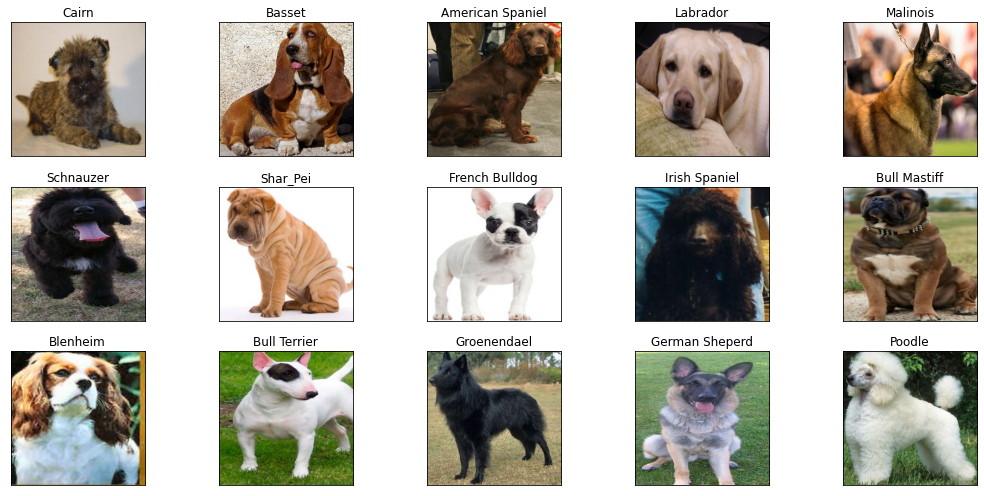

In [ ]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (15, 7), 
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(train_df.Filepath[i]))
  ax.set_title(train_df.Labels[i])



plt.tight_layout()
plt.show()  

Load the Images with a generator and data Augmentation

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df, 
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 0,
    #subset = 'training',
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_images = val_generator.flow_from_dataframe(
    dataframe = val_df, 
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 0,
    #subset = 'training',
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df, 
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
    )

Found 7946 validated image filenames belonging to 70 classes.
Found 700 validated image filenames belonging to 70 classes.
Found 700 validated image filenames belonging to 70 classes.


Load the pretrained model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)

pretrained_model.trainable = False

Train the model

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation = 'relu')(pretrained_model.output)

x = tf.keras.layers.Dense(128, activation = 'relu')(x)

outputs = tf.keras.layers.Dense(70, activation = 'softmax')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)


model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
history = model.fit(train_images, validation_data = val_images, epochs = 5, 
                    batch_size = 32, verbose = 1)

Epoch 1/5
249/249 [==============================] - 258s 1s/step - loss: 0.9228 - accuracy: 0.7645 - val_loss: 0.4795 - val_accuracy: 0.9043
Epoch 2/5
249/249 [==============================] - 245s 986ms/step - loss: 0.2505 - accuracy: 0.9211 - val_loss: 0.4380 - val_accuracy: 0.9243
Epoch 3/5
249/249 [==============================] - 241s 969ms/step - loss: 0.1813 - accuracy: 0.9393 - val_loss: 0.5231 - val_accuracy: 0.9086
Epoch 4/5
249/249 [==============================] - 241s 968ms/step - loss: 0.1249 - accuracy: 0.9580 - val_loss: 0.5120 - val_accuracy: 0.9129
Epoch 5/5
249/249 [==============================] - 240s 963ms/step - loss: 0.0908 - accuracy: 0.9693 - val_loss: 0.5139 - val_accuracy: 0.9243


In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
249/249 [==============================] - 266s 1s/step - loss: 0.9867 - accuracy: 0.7506 - val_loss: 0.4627 - val_accuracy: 0.9057
Epoch 2/50
249/249 [==============================] - 255s 1s/step - loss: 0.2696 - accuracy: 0.9167 - val_loss: 0.4718 - val_accuracy: 0.9214
Epoch 3/50
249/249 [==============================] - 254s 1s/step - loss: 0.1825 - accuracy: 0.9401 - val_loss: 0.4678 - val_accuracy: 0.9214
Epoch 4/50
249/249 [==============================] - 254s 1s/step - loss: 0.1209 - accuracy: 0.9591 - val_loss: 0.4374 - val_accuracy: 0.9286
Epoch 5/50
249/249 [==============================] - 254s 1s/step - loss: 0.0904 - accuracy: 0.9694 - val_loss: 0.4421 - val_accuracy: 0.9400
Epoch 6/50
249/249 [==============================] - 252s 1s/step - loss: 0.0671 - accuracy: 0.9768 - val_loss: 0.4742 - val_accuracy: 0.9314
Epoch 7/50
249/249 [==============================] - 252s 1s/step - loss: 0.0574 - accuracy: 0.9801 - val_loss: 0.4724 - val_accuracy: 0.9343

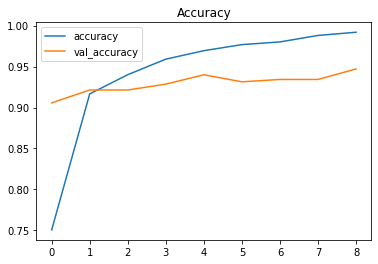

In [ ]:
  pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

  plt.title('Accuracy')
  plt.show()

Visualize the result

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.15603
Test Accuracy: 94.29%


Predict the label of the test_images

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Pekinese', 'Maltese', 'Cockapoo', 'German Sheperd', 'Pekinese']


Display the result

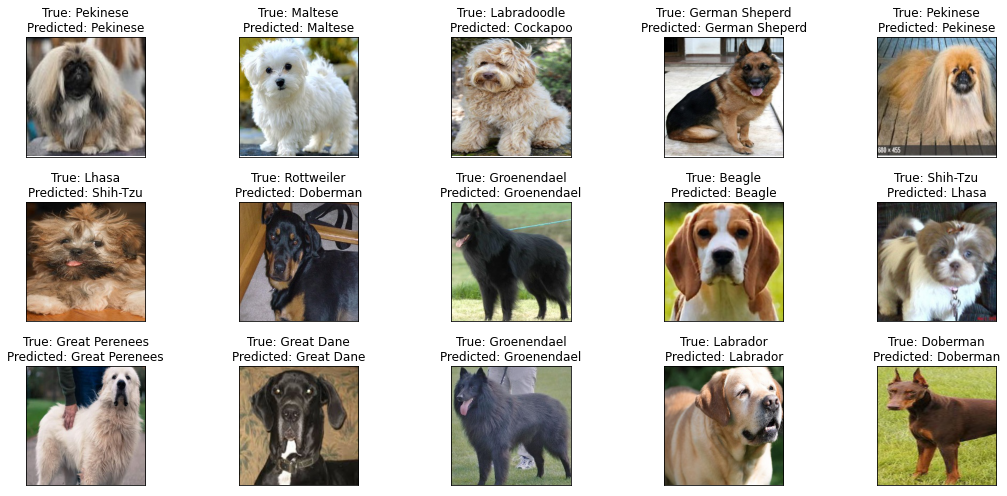

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Labels.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()